
Attaching package: ‘dplyr’




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.5.1     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: lattice




Attaching package: ‘caret’




The following object is masked from ‘package:purrr’:

    lift




The following object is masked from ‘package:tensorflow’:

    train




The following object is masked from ‘package:httr’:

    progress




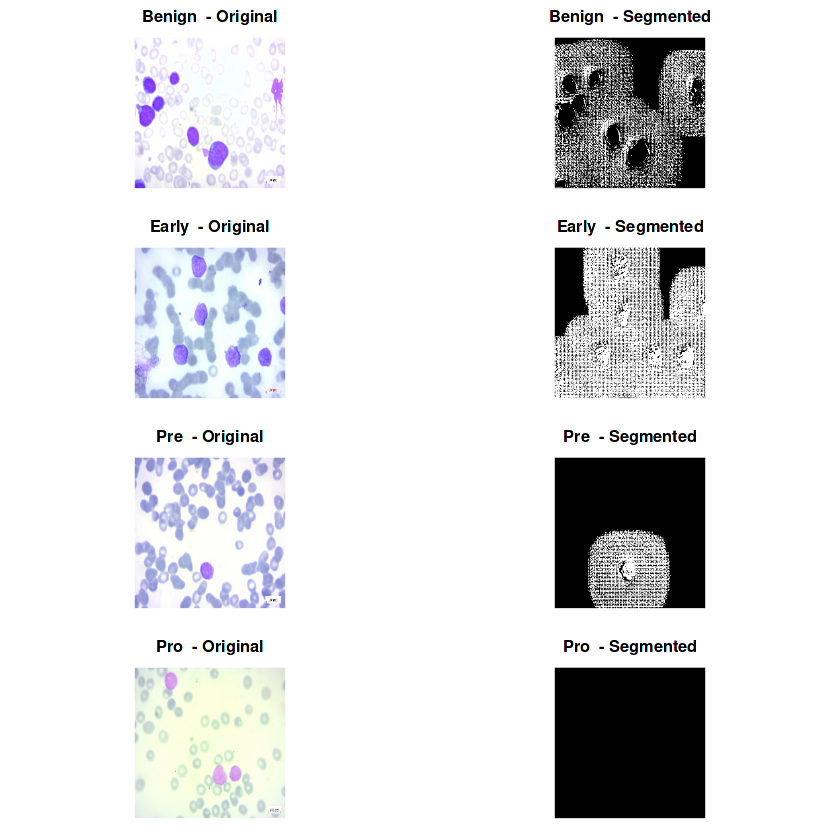

In [1]:
# Load necessary libraries
library(keras)
library(tensorflow)
library(dplyr)  # For data manipulation
library(tidyverse)  # For tidyverse functions
library(caret)  # For confusionMatrix and stratified sampling

# Set the path to your dataset
data_dir <- "/kaggle/input/leukemia-images/Original"

# Define image size and parameters for ConvNeXT
img_height <- 224
img_width <- 224
batch_size <- 32
epochs <- 150

# Gather file paths and corresponding labels
file_paths <- c()
class_labels <- c()

for (class in c("Benign", "Early", "Pre", "Pro")) {
  class_path <- file.path(data_dir, class)
  files <- list.files(class_path, full.names = TRUE)
  unique_files <- unique(files)
  file_paths <- c(file_paths, unique_files)
  class_labels <- c(class_labels, rep(class, length(unique_files)))
}

# Create DataFrame with the necessary structure
full_df <- data.frame(
  image_filename = file_paths,
  class = class_labels,
  stringsAsFactors = FALSE
)

# Initialize storage for images
original_images <- list()
segmented_images <- list()

# Loop through one image from each class
par(mfrow = c(4, 2))  # Set up the plotting grid to show images from each class

for (class in unique(full_df$class)) {
    #Get one sample image for the current class
    sample_image_path <- full_df$image_filename[full_df$class == class][1]
          
    # Load the image
    input_image <- image_load(sample_image_path, target_size = c(img_height, img_width))
    input_image_array <- image_to_array(input_image)
    input_image_array <- array_reshape(input_image_array, c(1, img_height, img_width, 3)) / 255
    
    # Store original image
    original_image <- input_image_array[1,,,]
    original_images[[class]] <- original_image
    
    # Set the color threshold for purple in HSV space
    lower_purple <- c(0.7, 0.5, 0.4)  # Adjust as needed
    upper_purple <- c(0.8, 1.0, 1.0)  # Adjust as needed
    
    # Define the model input layer
    input_image <- layer_input(shape = c(img_height, img_width, 3))
    
    # Convert the input image to HSV
    input_image_hsv <- tf$image$rgb_to_hsv(input_image)
    
    # Create a binary mask for purple regions (lymphoblasts) based on the HSV threshold
    mask_purple <- tf$math$logical_and(
      input_image_hsv[,,,1] >= lower_purple[1], input_image_hsv[,,,1] <= upper_purple[1]
    )
    mask_purple <- tf$math$logical_and(mask_purple, input_image_hsv[,,,2] >= lower_purple[2])
    mask_purple <- tf$math$logical_and(mask_purple, input_image_hsv[,,,3] >= lower_purple[3])
    
    # Convert logical mask to float and expand dims to match RGB channels
    mask_purple <- tf$cast(mask_purple, dtype = tf$float32)  # Ensure the mask is a float tensor
    mask_purple <- tf$expand_dims(mask_purple, axis = as.integer(-1)) # Add a channel dimension
    mask_purple <- tf$tile(mask_purple, multiples = as.integer(c(1, 1, 1, 3)))  # Repeat for each color channel
    
    # Apply the mask to the original RGB image
    segmented_image <- tf$math$multiply(input_image, mask_purple)
    
    # Pass the segmented image into segmentation block
    # Modified U-Net inspired segmentation block with color-based segmentation
    # Contracting Path (Encoder) with fewer filters
    conv1 <- layer_conv_2d(segmented_image, filters = 32, kernel_size = c(3, 3), activation = "relu", padding = "same")
    conv1 <- layer_conv_2d(conv1, filters = 32, kernel_size = c(3, 3), activation = "relu", padding = "same")
    pool1 <- layer_max_pooling_2d(conv1, pool_size = c(2, 2))
    
    conv2 <- layer_conv_2d(pool1, filters = 64, kernel_size = c(3, 3), activation = "relu", padding = "same")
    conv2 <- layer_conv_2d(conv2, filters = 64, kernel_size = c(3, 3), activation = "relu", padding = "same")
    pool2 <- layer_max_pooling_2d(conv2, pool_size = c(2, 2))
    
    conv3 <- layer_conv_2d(pool2, filters = 128, kernel_size = c(3, 3), activation = "relu", padding = "same")
    conv3 <- layer_conv_2d(conv3, filters = 128, kernel_size = c(3, 3), activation = "relu", padding = "same")
    pool3 <- layer_max_pooling_2d(conv3, pool_size = c(2, 2))
    
    # Bottleneck layer with fewer filters
    conv4 <- layer_conv_2d(pool3, filters = 256, kernel_size = c(3, 3), activation = "relu", padding = "same")
    conv4 <- layer_conv_2d(conv4, filters = 256, kernel_size = c(3, 3), activation = "relu", padding = "same")
    
    # Expansive Path (Decoder) with skip connections and fewer filters
    
    # Upsampling + skip connection from conv3
    upconv3 <- layer_conv_2d_transpose(conv4, filters = 128, kernel_size = c(3, 3), strides = c(2, 2), padding = "same")
    concat3 <- layer_concatenate(list(upconv3, conv3))
    conv5 <- layer_conv_2d(concat3, filters = 128, kernel_size = c(3, 3), activation = "relu", padding = "same")
    conv5 <- layer_conv_2d(conv5, filters = 128, kernel_size = c(3, 3), activation = "relu", padding = "same")
    
    # Upsampling + skip connection from conv2
    upconv2 <- layer_conv_2d_transpose(conv5, filters = 64, kernel_size = c(3, 3), strides = c(2, 2), padding = "same")
    concat2 <- layer_concatenate(list(upconv2, conv2))
    conv6 <- layer_conv_2d(concat2, filters = 64, kernel_size = c(3, 3), activation = "relu", padding = "same")
    conv6 <- layer_conv_2d(conv6, filters = 64, kernel_size = c(3, 3), activation = "relu", padding = "same")
    
    # Upsampling + skip connection from conv1
    upconv1 <- layer_conv_2d_transpose(conv6, filters = 32, kernel_size = c(3, 3), strides = c(2, 2), padding = "same")
    concat1 <- layer_concatenate(list(upconv1, conv1))
    conv7 <- layer_conv_2d(concat1, filters = 32, kernel_size = c(3, 3), activation = "relu", padding = "same")
    conv7 <- layer_conv_2d(conv7, filters = 32, kernel_size = c(3, 3), activation = "relu", padding = "same" )

    # Add final segmentation output layer
    output_segmentation <- layer_conv_2d(
      conv7, 
      filters = 1,  
      kernel_size = c(1, 1), 
      activation = "sigmoid",  
      padding = "same",
      name = "segmentation_output"
    )
    
    # Create Keras functional model for segmentation
    segmentation_model <- keras_model(
      inputs = input_image, 
      outputs = output_segmentation
    )
    
    # Prediction on input image
    segmented_prediction <- predict(segmentation_model, input_image_array)
    
    # Process segmentation prediction
    segmented_image_array <- array(
      ifelse(segmented_prediction[1,,,1] > 0.5, 1, 0), 
      dim = c(img_height, img_width)
    )
    
    # Store segmented image
    segmented_images[[class]] <- segmented_image_array

}

# Visualization with correct aspect ratio
par(mfrow = c(length(original_images), 2), mar = c(1, 1, 2, 1))

# Plot original and segmented images for each class
for (class in names(original_images)) {
    # Original image
    plot(1:img_width, 1:img_height, type = "n", axes = FALSE, xlab = "", ylab = "", asp = 1)
    rasterImage(original_images[[class]], 1, 1, img_width, img_height)
    title(paste(class, " - Original"))
    
    # Segmented image
    plot(1:img_width, 1:img_height, type = "n", axes = FALSE, xlab = "", ylab = "", asp = 1)
    rasterImage(segmented_images[[class]], 1, 1, img_width, img_height)
    title(paste(class, " - Segmented"))
}